## Q1. Downloading the data

In [ ]:
!curl -o ./data/yellow_tripdata_2023-01.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
!curl -o ./data/yellow_tripdata_2023-02.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet


In [2]:
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [4]:
jan_2023 = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet', engine='pyarrow')
feb_2023 = pd.read_parquet('../data/yellow_tripdata_2023-02.parquet', engine='pyarrow')


In [ ]:
print("Number of rows in the dataset: ", jan_2023.shape[0])
print("Number of columns in the dataset: ", jan_2023.shape[1])  

## Q2. Computing duration

In [5]:
jan_2023['duration'] = jan_2023['tpep_dropoff_datetime'] - jan_2023['tpep_pickup_datetime']
feb_2023['duration'] = feb_2023['tpep_dropoff_datetime'] - feb_2023['tpep_pickup_datetime']

In [6]:
jan_2023['duration'] = jan_2023['duration'].dt.total_seconds()/60
feb_2023['duration'] = feb_2023['duration'].dt.total_seconds()/60

In [7]:
jan_2023['duration'].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [8]:
print('Standard deviation', round(jan_2023['duration'].describe()['std'], 2))

Standard deviation 42.59


## Q3. Dropping outliers

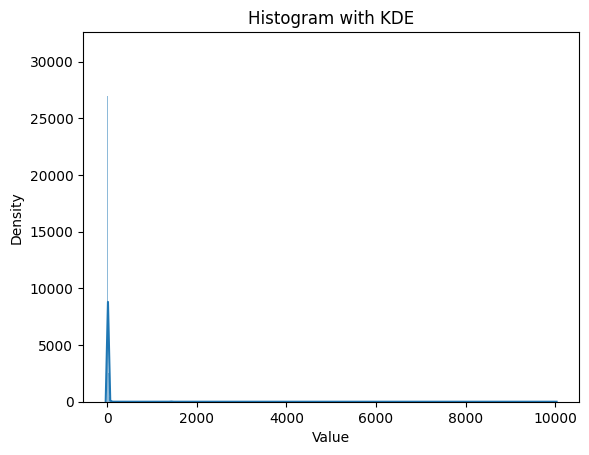

In [9]:
#view distribution
sns.histplot(jan_2023['duration'], kde=True)
plt.title("Histogram with KDE")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

In [10]:
print('fraction of the records to be left after outliers are dropped: ', round((jan_2023[(jan_2023['duration'] > 1) & (jan_2023['duration'] < 60)].shape[0] / jan_2023.shape[0])* 100.0, 2))     

fraction of the records to be left after outliers are dropped:  98.11


In [19]:
#outliers dropped
jan_2023 = jan_2023[(jan_2023['duration'] > 1) & (jan_2023['duration'] < 60)]
feb_2023 = feb_2023[(feb_2023['duration'] > 1) & (feb_2023['duration'] < 60)]

## Q4. One-hot encoding

In [20]:
categorical = ['PULocationID', 'DOLocationID']

# Convert categorical columns to string type    
jan_2023[categorical] = jan_2023[categorical].astype(str)
feb_2023[categorical] = feb_2023[categorical].astype(str)   

In [21]:
train_dicts = jan_2023[categorical].to_dict(orient='records')
val_dicts = feb_2023[categorical].to_dict(orient='records') 


dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
print(X_train.shape)

X_val = dv.transform(val_dicts)   


(3008849, 515)


In [22]:
print("Dimensionality of this matrix(colums):", X_train.shape[1])   

Dimensionality of this matrix(colums): 515


## Q5. Training a model

In [23]:
target = 'duration'
y_train = jan_2023[target].values
y_val = feb_2023[target].values



In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)


In [25]:
print("RMSE of the model on the training data", round(root_mean_squared_error(y_train, y_pred), 2))

RMSE of the model on the training data 7.65


/var/folders/09/jh17980x0sb1bnyhv2cm8dlh0000gn/T/ipykernel_45631/437147669.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/09/jh17980x0sb1bnyhv2cm8dlh0000gn/T/ipykernel_45631/437147669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label

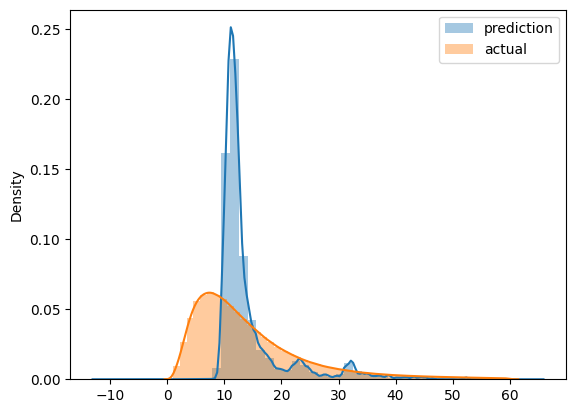

In [26]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()


## Q6. Evaluating the model

In [27]:
# y_test = feb_2023[target].values
fby_pred = lr.predict(X_val)

print("RMSE of the model on the validation data:", round(root_mean_squared_error(y_val, fby_pred), 2))

RMSE of the model on the validation data: 7.81
